In [1]:
import os
import pickle
from collections import Counter
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
IS_LOCAL = True

import os

if IS_LOCAL:
    PATH="input"
else:
    PATH="../input"
    
print(os.listdir(PATH))

['train.csv.zip', 'test.csv', 'sample_submission.csv.zip', 'test.csv.zip', 'train.csv', 'sample_submission.csv']


In [2]:
#train_df = pd.read_csv(os.path.join(PATH, "train.csv"))
#test_df = pd.read_csv(os.path.join(PATH, "test.csv"))

with open('cache/traintest.pkl', 'rb') as f:
    train_data, test_data, train_y = pickle.load(f)

In [3]:
train_data.shape

(4459, 4735)

In [5]:
def _to_ignore(df_train):
    def low_variance(df_train):
        s = VarianceThreshold(threshold=.0)
        s.fit(df_train)
        idxs = s.get_support()
        to_remove = [c for c, x in zip(df_train.columns, idxs) if not x]
        return to_remove

    def nunique(df_train):
        _, index = np.unique(df_train.values, return_index=True, axis=1)
        return [c for idx, c in enumerate(df_train.columns) if idx not in index]

    def suspicious(df_train):
        # drop zero fraction
        thr = 0.98
        to_ignore = []
        for column in df_train.columns:
            counts = df_train[column].value_counts()
            value_fraction = counts[0] / len(df_train)
            if value_fraction >= thr:
                to_ignore.append(column)
        return to_ignore

    to_ignore = set()
    to_ignore |= set(low_variance(df_train))
    to_ignore |= set(nunique(df_train))
    to_ignore |= set(suspicious(df_train))
    return to_ignore


In [7]:
from sklearn.feature_selection import VarianceThreshold    
from sklearn import preprocessing, model_selection, metrics

to_ignore = _to_ignore(train_data)
features = [c for c in train_data if c not in to_ignore]

In [9]:
df_train = train_data[features]

In [16]:
columns = list(df_train.columns)
limits = np.max(df_train, axis=0)

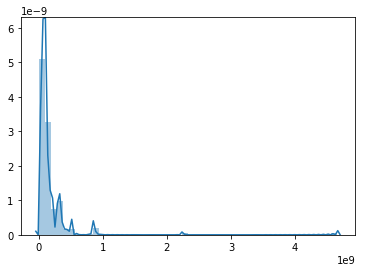

In [19]:
sns.distplot(limits)

(4459, 2121)

In [ ]:
def remove_constants():
    dtypes = train_df.dtypes.to_dict()
    print(f"train shape: {train_df.shape}, test shape: {test_df.shape}")

    train_target = np.log1p(train_df['target'].values)

    ntrain = train_df.shape[0]
    ntest  = test_df.shape[0]
    print('ntrain: ', ntrain, ' ntest: ', ntest)

    ignored_columns = ['ID', 'target']
    feature_columns = [c for c in train_df.columns if c not in ignored_columns]    

    # concatencate everything train + test...
    df_all = pd.concat([train_df[feature_columns], test_df[feature_columns]]).astype(np.float32)

    dtype_counter = Counter()
    unique_counter = Counter()
    for c in feature_columns:
        dtype_str = str(dtypes[c])
        dtype_counter[dtype_str] += 1
        unique = len(set(train_df[c].values))
        unique_counter[unique] += 1
        if unique == 1:
            ignored_columns.append(c)

    df_all = df_all[[c for c in df_all.columns if c not in ignored_columns]]
    train_data = df_all.iloc[0:ntrain, :]
    test_data  = df_all.iloc[ntrain:, :]
    return train_data, test_data, train_target
        
    

In [22]:

with open('cache/traintest.pkl', 'wb') as f:
    pickle.dump([train_data, test_data, train_target], f)

In [3]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

def build_decomposition2(df_train, df_test, n_comp):
    tfa = FactorAnalysis(n_components=n_comp, random_state=0)
    tfa_results_train = tfa.fit_transform(df_train)
    tfa_results_test = tfa.transform(df_test)    
        
    srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=0)
    srp_results_train = srp.fit_transform(df_train)
    srp_results_test = srp.transform(df_test)
    
    out_train = pd.DataFrame()
    out_test = pd.DataFrame()
    
    # Append decomposition components to datasets
    for i in range(n_comp):
        out_train['tfa_' + str(i)] = tfa_results_train[:, i]
        out_test['tfa_' + str(i)] = tfa_results_test[:, i]

        out_train['srp_' + str(i)] = srp_results_train[:, i]
        out_test['srp_' + str(i)] = srp_results_test[:, i]

    return out_train, out_test

    
def build_decomposition(df_train, df_test, n_comp):
    # tSVD
    print('tsvd')
    tsvd = TruncatedSVD(n_components=n_comp, random_state=0)
    tsvd_results_train = tsvd.fit_transform(df_train)
    tsvd_results_test = tsvd.transform(df_test)

    # PCA
    print('pca')
    pca = PCA(n_components=n_comp, random_state=0)
    pca2_results_train = pca.fit_transform(df_train)
    pca2_results_test = pca.transform(df_test)

    # ICA
    print('ica')
    ica = FastICA(n_components=n_comp, random_state=0)
    ica2_results_train = ica.fit_transform(df_train)
    ica2_results_test = ica.transform(df_test)

    # GRP
    print('grp')
    grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=0)
    grp_results_train = grp.fit_transform(df_train)
    grp_results_test = grp.transform(df_test)

    # SRP
    print('srp')
    srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=0)
    srp_results_train = srp.fit_transform(df_train)
    srp_results_test = srp.transform(df_test)

    out_train = pd.DataFrame()
    out_test = pd.DataFrame()
    
    # Append decomposition components to datasets
    for i in range(n_comp):
        out_train['pca_' + str(i)] = pca2_results_train[:, i]
        out_test['pca_' + str(i)] = pca2_results_test[:, i]

        out_train['ica_' + str(i)] = ica2_results_train[:, i]
        out_test['ica_' + str(i)] = ica2_results_test[:, i]

        out_train['tsvd_' + str(i)] = tsvd_results_train[:, i]
        out_test['tsvd_' + str(i)] = tsvd_results_test[:, i]

        out_train['grp_' + str(i)] = grp_results_train[:, i]
        out_test['grp_' + str(i)] = grp_results_test[:, i]

        out_train['srp_' + str(i)] = srp_results_train[:, i]
        out_test['srp_' + str(i)] = srp_results_test[:, i]

    return out_train, out_test



In [18]:
out50_train, out50_test = build_decomposition(train_data, test_data, 50)

tsvd
pca
ica
grp
srp


In [19]:
with open('cache/traintest_decomposition50.pkl', 'wb') as f:
    pickle.dump([out50_train, out50_test], f)

In [20]:
out100_train, out100_test = build_decomposition(train_data, test_data, 100)
with open('cache/traintest_decomposition100.pkl', 'wb') as f:
    pickle.dump([out100_train, out100_test], f)

tsvd
pca
ica
grp
srp


In [4]:
out50_train, out50_test = build_decomposition2(train_data, test_data, 50)
with open('cache/traintest_decomposition2_50.pkl', 'wb') as f:
    pickle.dump([out50_train, out50_test], f)

In [13]:
def quantile(x, q):
    return np.percentile(x, q=q)

def aggregates(df_train, df_test):
    import pandas as pd
    from scipy.stats import skew, kurtosis
    def aggregate_row(row):
        non_zero_values = row.iloc[row.nonzero()].dropna(how='all')
        aggs = {'non_zero_mean': non_zero_values.mean(),
                'non_zero_std': non_zero_values.std(),
                'non_zero_max': non_zero_values.max(),
                'non_zero_min': non_zero_values.min(),
                'non_zero_sum': non_zero_values.sum(),
                'non_zero_skewness': skew(non_zero_values),
                'non_zero_kurtosis': kurtosis(non_zero_values),
                'non_zero_median': non_zero_values.median(),
                #'non_zero_q1': quantile(non_zero_values, 25),
                #'non_zero_q3': quantile(non_zero_values, 75),
                'non_zero_log_mean': np.log1p(non_zero_values).mean(),
                'non_zero_log_std': np.log1p(non_zero_values).std(),
                'non_zero_log_max': np.log1p(non_zero_values).max(),
                'non_zero_log_min': np.log1p(non_zero_values).min(),
                'non_zero_log_sum': np.log1p(non_zero_values).sum(),
                'non_zero_log_skewness': skew(np.log1p(non_zero_values)),
                'non_zero_log_kurtosis': kurtosis(np.log1p(non_zero_values)),
                'non_zero_log_median': np.log1p(non_zero_values).median(),
                #'non_zero_log_q1': quantile(np.log1p(non_zero_values), 25),
                #'non_zero_log_q3': quantile(np.log1p(non_zero_values), 75),
                'non_zero_count': non_zero_values.count(),
                'non_zero_fraction': non_zero_values.count() / row.count()
                }
        return pd.Series(aggs)
    agg_train = df_train.apply(aggregate_row, axis=1)
    agg_test = df_test.apply(aggregate_row, axis=1)
    return agg_train, agg_test
    

In [14]:
agg_train, agg_test = aggregates(train_data, test_data)
with open('cache/non_zero_stats.pkl', 'wb') as f:
    pickle.dump([agg_train, agg_test], f)